## Imports

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import GPy as gpy
import corner as corner

# matplotlib style sheet
plt.style.use('../../neutron_stars_tf/etf/style_1.mplstyle')

# Load data

In [14]:
name = 'LD'

if name == 'DZ':
    data = np.loadtxt('DZ_residuals.dat')
elif name == 'LD':
    data = np.loadtxt('LDM_residuals.dat')

thin = 10
X = data[::thin,1:3]
Y = np.atleast_2d(data[::thin,3]).T

# Create kernel and GPy model

In [15]:
kernel = gpy.kern.RBF(input_dim=2, variance=1., lengthscale=(1., 1.), ARD=True)
# Fix GP noise parameter to average scale of experimental uncertainty, 0.0235 MeV, as done in Neufcourt et al.
model = gpy.models.GPRegression(X, Y, kernel=kernel, noise_var=0.0235)
model.Gaussian_noise.variance.fix()

array([0])

In [16]:
# Constrain RBF kernel hyperparameters to reasonable ranges
model.rbf.variance.constrain_bounded(0., 20.)
model.rbf.lengthscale.constrain_bounded(0.1, 10.)
model

reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.lengthscale


GP_regression.,value,constraints,priors
rbf.variance,1.0,"0.0,20.0",
rbf.lengthscale,"(2,)","0.1,10.0",
Gaussian_noise.variance,0.0235,+ve fixed,


# Hyperparameter optimisation using ML

In [17]:
model.optimize()

In [18]:
# Hyperparameters after optimization
ML_values = model.rbf.param_array
ML_values

array([8.87113434, 4.11779498, 4.03852412])

# HMC inference of kernel hyperparameters

In [19]:
hmc = gpy.inference.mcmc.HMC(model, stepsize=5e-2)

In [21]:
samples = hmc.sample(num_samples=1000)
model

KeyboardInterrupt: 

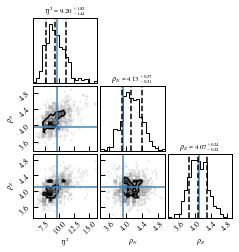

In [27]:
rcParams['axes.grid'] = False

fig, axs = plt.subplots(3, 3, figsize=(3.4, 3.4))

fig = corner.corner(samples[300:,:],
                    labels=[r'$\eta^2$',r'$\rho_N$',r'$\rho_Z$'],
                    label_kwargs={"fontsize": 7},
                    show_titles=True,
                    title_fmt='.2f',
                    title_kwargs={"fontsize": 7},
                    truths=ML_values,
                    quantiles=[0.16, 0.5, 0.84],
                    max_n_ticks=5,
                    levels=[1-np.exp(-0.5)],
                    fig=fig)

fig.savefig(name+'_cornerGPHypPars.pdf')

# Predictions

In [28]:
# GP predictions at original inputs
mean, cov = model.predict_noiseless(X)

# Save to file
np.savetxt(name+'_GPPredictionsOriginalInput.dat',
           np.hstack((X, mean, cov)),
           fmt=('\t%d', '\t%d', '\t%.9e', '\t%.9e'),
           header='\tN\tZ\tmeans\t\t\t\tcovs')

In [29]:
"""
Unknown points
Test with Z=30; N=53 to N=100
"""
NNew = np.arange(53, 101, 1, dtype='int')
ZNew = np.repeat(30, len(NNew))
XNew = np.vstack((NNew, ZNew)).T

# GP predictions at unknown points
meanNew, covNew = model.predict_noiseless(XNew)

# Save to file
np.savetxt(name+'_GPPredictionsNewInput.dat',
           np.hstack((XNew, meanNew, covNew)),
           fmt=('\t%d', '\t%d', '\t%.9e', '\t%.9e'),
           header='\tN\tZ\tmeans\t\t\t\tcovs')

# Plot

In [33]:
difference = mean - Y
print(difference.mean(), difference.std())
print(mean.std())

-0.011955610288066052 0.21386823984753753
2.930876917025275


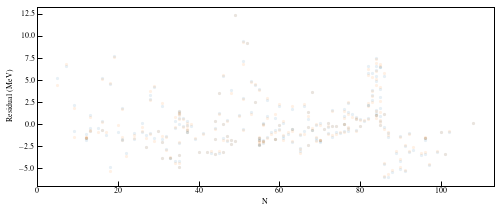

In [31]:
colours = [plt.cm.tab10(i) for i in range(10)]

fig, axs = plt.subplots(1, 1, figsize=(7, 3))

axs.plot(X[:,1], Y,
         alpha=0.1, color=colours[0], fillstyle='full', ls='none', marker='o', mew=0.1)
axs.plot(X[:,1], mean,
         alpha=0.1, color=colours[1], fillstyle='full', ls='none', marker='o', mew=0.1)

axs.set_xlabel('N')
axs.set_ylabel('Residual (MeV)')

fig.tight_layout()
fig.savefig(name+'_residualsDifference.pdf')